# AST4310, Autumn 2020, Project 4
## Authored by 15908 & 15907

In [3]:
%%javascript  # Allow equation numbers
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

Including necessary imports.

In [4]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from astropy import units, constants
from astropy.table import QTable  # to use tables with units
from astropy.modeling.models import BlackBody  # to compute the Planck function
from astropy.visualization import quantity_support
from IPython.display import set_matplotlib_formats, HTML, display
from numpy import newaxis as nax  # to simplify the many uses of this

quantity_support()
set_matplotlib_formats('svg')
plt.rc('legend', frameon=False)
plt.rc('figure', figsize=(7, 7 / 1.75)) # Larger figure sizes
plt.rc('font', size=12)

from scipy.integrate import cumtrapz   # for tau integration
from scipy.special import wofz   # for Voigt function

i_units = "kW m-2 sr-1 nm-1"  # More practical SI units

## Introduction

In [5]:
def read_table_units(filename):
    """
    Reads a table in a text file, formatted with column names in first row,
    and unit names on second row. Any deviation from this format will fail.
    """
    tmp = np.genfromtxt(filename, names=True)
    unit_names = open(filename).readlines()[1][1:].split()
    # Convert to astropy QTable to have units
    data = QTable(tmp)
    # Assign units to quantities in table, use SI units
    for key, unit in zip(data.keys(), unit_names):
        data[key].unit = unit
        data[key] = data[key].si  # We don't want to use deprecated units
    return data

In [6]:
falc = read_table_units("falc.dat")
print(falc.keys())

['height', 'tau_500', 'colmass', 'temperature', 'v_turb', 'hydrogen_density', 'proton_density', 'electron_density', 'pressure', 'p_ratio', 'density']


Plotting total pressure against column mass.
In hydrostatic equilibrium total pressure has to balance gravity. For a location in the atmosphere can write this requirement as 
\begin{equation}
    \vec{F}_P = -\vec{F}_G = -M\vec{g}(\vec{r})\,,
    \label{eq:pressure}
\end{equation}
where $\vec{F}_P$ is the total pressure force, and $\vec{F}_G$ is the gravitational force exerted by the mass above. 
In the atmosphere the gravitational pull is approximately constant, and $\vec{g}(\vec{r}) \approx g$ with direction towards the interior. This is because most of the mass is located at the interior, and we are looking at a relatively short region above the surface.

We can rewrite the total pressure force as total pressure times area. $F_P = p_\textrm{tot} A$ with direction outwards from the sun. Under this reasoning, we can rewrite equation \eqref{eq:pressure} to 
$$ p_\textrm{tot} A = M g \Rightarrow p_\textrm{tot} = g \frac{M}{A}\,.$$
Here we make use of the quantity column mass, which is the mass above us at a cross section A. The mass in the falc table is expressed as column mass, at a cross section of 1 m$^2$. Denoting this column mass as lowercase $m$, we end up with
$$p_\textrm{tot} = g m\,.$$
Because $g$ is constant in the atmosphere, we expect column mass to scale linearly with total pressure. We extract total pressure and column mass over the surface of the sun from the falc table, and plot it.

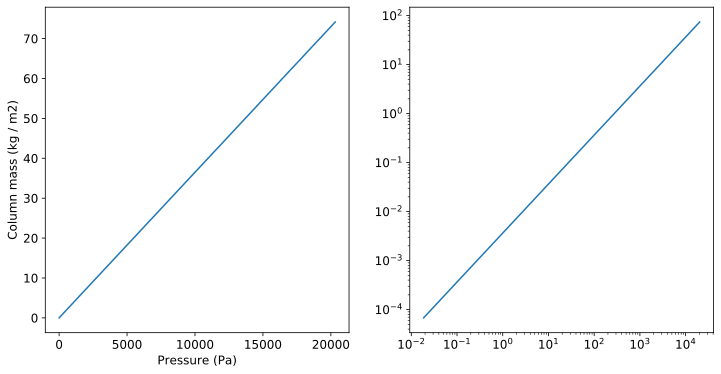

In [7]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
colmass = falc['colmass'].to("kg m-2")
pressure = falc['pressure'].to("Pa")
ax[0].plot(pressure, colmass)
ax[1].loglog(pressure.value, colmass.value);
ax[0].set_ylabel("Column mass (%s)" %colmass.unit)
ax[0].set_xlabel("Pressure (%s)" %pressure.unit);

From inspection of the data, we see that our expectations were correct. In the above plots the column mass indeed scales linearly against total pressure. 

Plotting the ratio of hydrogen mass density to the total mass density against height

Average Hydrogen mass ratio: 0.713843. Average Hydrogen + Helium mass ratio: 0.997239.
Mass ratio of metals: 0.002761.


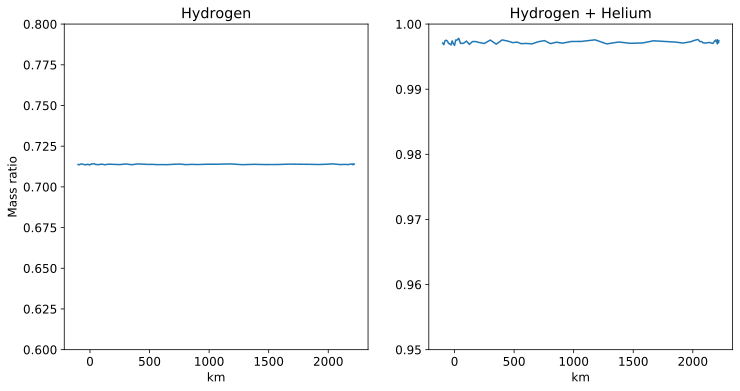

In [8]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
height = falc["height"].to("km")
hydrogen_density = falc['hydrogen_density']
density = falc['density']
H_ratio = hydrogen_density*constants.m_p/density
H_He_ratio = (hydrogen_density*constants.m_p + 0.1*hydrogen_density*3.97*constants.m_p)/density
ax[0].plot(height, H_ratio)
ax[0].set_ylim(0.6,0.8)
ax[1].plot(height, H_He_ratio)
ax[1].set_ylim(0.95,1)
ax[0].set_title("Hydrogen")
ax[1].set_title("Hydrogen + Helium")
ax[0].set_ylabel("Mass ratio");
print("Average Hydrogen mass ratio: %.6f. Average Hydrogen + Helium mass ratio: %.6f." \
      %(np.average(H_ratio),np.average(H_He_ratio)))
print("Mass ratio of metals: %.6f." %np.average(1 - H_He_ratio.value))

Plotting gas pressure against height.

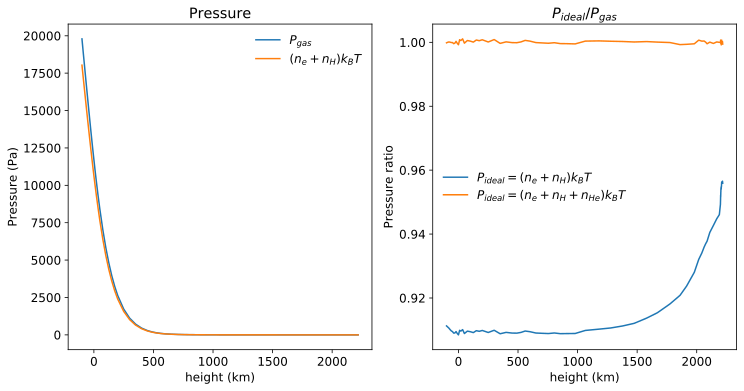

In [9]:
p_gas = pressure*falc['p_ratio']
electron_density = falc['electron_density']
temperature = falc['temperature']
p_ideal = ((hydrogen_density + electron_density)*constants.k_B*temperature).to('Pa')
p_ideal_new = p_ideal + 0.1*hydrogen_density*constants.k_B*temperature
fig,ax = plt.subplots(1,2,figsize=(12,6))
ax[0].plot(height, p_gas, label=r"$P_{gas}$")
ax[0].plot(height, p_ideal, label=r"$(n_e + n_H)k_B T$")
ax[0].set_ylabel("Pressure (%s)" %p_gas.unit)
ax[0].set_title("Pressure")
ax[0].set_xlabel("height (%s)" %height.unit)
ax[0].legend()
ax[1].plot(height, p_ideal/p_gas,label=r"$P_{ideal} = (n_e + n_H)k_B T$")
ax[1].plot(height, p_ideal_new/p_gas,label=r"$P_{ideal} = (n_e + n_H + n_{He})k_B T$")
ax[1].set_ylabel("Pressure ratio")
ax[1].set_xlabel("height (%s)" %height.unit)
ax[1].set_title(r"$P_{ideal}/P_{gas}$")
ax[1].legend();

Plotting fraction of ionized hydrogen

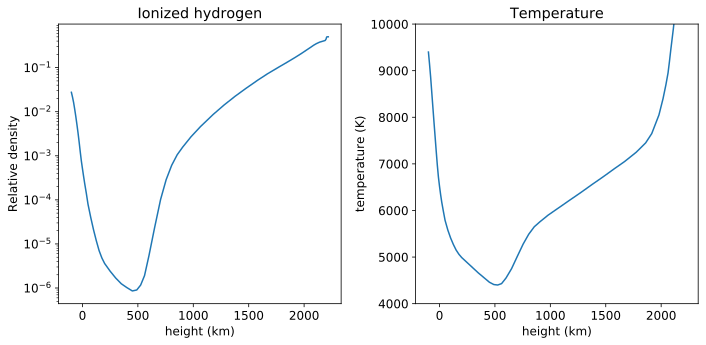

In [10]:
proton_density = falc['proton_density']
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].semilogy(height, proton_density/(hydrogen_density+proton_density))
ax[0].set_title("Ionized hydrogen")
ax[0].set_ylabel("Relative density")
ax[0].set_xlabel("height (%s)" %height.unit)
ax[1].plot(height, temperature.value)
ax[1].set_title("Temperature")
ax[1].set_xlabel("height (%s)" %height.unit)
ax[1].set_ylabel("temperature (%s)" %temperature.unit)
ax[1].set_ylim(4000, 10000)
plt.tight_layout();

Plotting photon and hydrogen density

Photon and hydrogen density at the deepest model location: 2.00e+16 m-3 and 5.57e+15 m-3
Photon and hydrogen density in the upper atmosphere:       6.14e+11 m-3 and 1.35e+23 m-3.


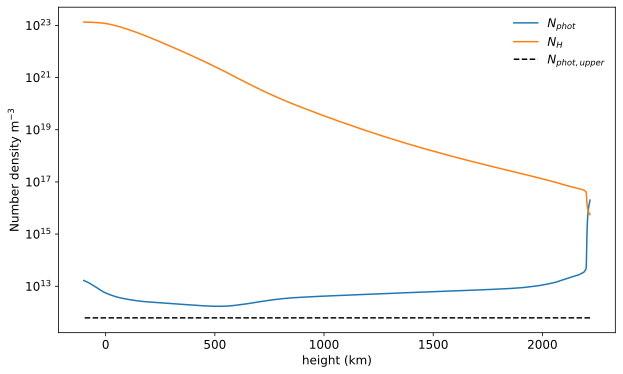

In [44]:
T_eff = 5777*units.K
N_phot = 20*temperature**3
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel("height (%s)" %height.unit)
ax.set_ylabel(r"Number density m$^{-3}$")
ax.semilogy(height, (N_phot).value,label=r"$N_{phot}$")
ax.semilogy(height, (hydrogen_density).value,label=r"$N_{H}$")
ax.semilogy(height, 20*T_eff**3/(2*np.pi)*np.ones(len(height)), color='k', ls='--', label=r"$N_{phot, upper}$")
ax.legend();
print("Photon and hydrogen density at the deepest model location: %.2e m-3 and %.2e m-3"\
      %(N_phot[0].value, hydrogen_density[0].value))
print("Photon and hydrogen density in the upper atmosphere:       %.2e m-3 and %.2e m-3."\
      %((20*T_eff**3/(2*np.pi)).value,hydrogen_density[-1].value))

Conjecture why this equation is not valid higher up in the atmosphere. Photons and hydrogen not in thermal equilibrium?

In [9]:
def compute_hminus_cross_section(wavelength, temperature, electron_density):
    """
    Computes the H minus extinction cross section, both free-free and
    bound-free as per Gray (1992).
    
    Parameters
    ----------
    wavelength : astropy.units.quantity (array)
        Wavelength(s) to calculate in units of length.
    temperature: astropy.units.quantity (scalar or array)
        Gas temperature in units of K or equivalent.
    electron_density: astropy.units.quantity (scalar or array)
        Electron density in units of per cubic length.
        
    Returns
    -------
    extinction : astropy.units.quantity (scalar or array)
        Total H- extinction in si units. 
        Shape: shape of temperature + (nwave,)
    """
    # Broadcast to allow function of temperature and wavelength
    temp = temperature[..., nax]
    wave = wavelength[nax]
    theta = 5040 * units.K / temp
    electron_pressure = electron_density[..., nax] * constants.k_B * temp
    # Compute bound-free opacity for H-, following Gray 8.11-8.12
    sigma_coeff = np.array([2.78701e-23, -1.39568e-18,  3.23992e-14, -4.40524e-10,
                               2.64243e-06, -1.18267e-05,  1.99654e+00])
    sigma_bf = np.polyval(sigma_coeff, wave.to_value('AA'))
    sigma_bf = sigma_bf * 1.e-22 * units.m ** 2
    # Set to zero above the H- ionisation limit at 1644.4 nm
    sigma_bf[wave > 1644.2 * units.nm] = 0.
    # convert into bound-free per neutral H atom assuming Saha,  Gray p156
    k_const = 4.158E-10 * units.cm ** 2 / units.dyn
    gray_saha = k_const * electron_pressure.cgs * theta ** 2.5 * 10. ** (0.754 * theta)
    kappa_bf = sigma_bf * gray_saha                    # per neutral H atom
    # correct for stimulated emission
    kappa_bf *= (1 - np.exp(-constants.h * constants.c / (wave * constants.k_B * temp))) 

    # Now compute free-free opacity, following Gray 8.13
    # coefficients for 4th degree polynomials in the log of wavelength (in AA)
    coeffs = np.array([[-0.0533464, 0.76661, -1.685, -2.2763],
                          [-0.142631, 1.99381, -9.2846, 15.2827],
                          [-0.625151, 10.6913, -67.9775, 190.266, -197.789]])
    log_wave = np.log10(wave.to_value('AA'))
    log_theta = np.log10(theta.value)
    tmp = 0
    for i in range(3):
        tmp += np.polyval(coeffs[i], log_wave) * (log_theta ** i)
    kappa_ff = electron_pressure * (10 ** tmp) 
    kappa_ff = kappa_ff * 1e-26 * (units.cm ** 4) / units.dyn
    return (kappa_bf + kappa_ff).si